# Loading and training on all models and features

In [1]:
from utils.splitters import k_fold_edge_split, train_test_split_edges
from utils.dataset_loader import load_dataframes
from model import Net
from utils.util_functions import train_model, device_finder, train_model_on_folds, predict_edges, plot_layers_curve, plotter, create_drugs_info_list_and_dict
from utils.util_functions import train_model_on_folds_and_decode_all, predict_new_edges, predict_top_edges, all_features_graph_data, save_preds_in_csv
from utils.util_functions import predict_all_top_edges, predict_top_new_edges, predict_all_features_top_edges, predict_all_features_top_new_edges, plot_comparison
import warnings
from utils.util_functions import decoding_drug_ids
from utils.graph_data_creater import create_graph_data_with_different_features, create_graph_data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.transforms import LocalDegreeProfile
import torch
import pathlib
import os
from torch_geometric.data import Data
import numpy as np
# plotting shapes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# ignoring warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
df_list = [final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df, all_df] = load_dataframes()
data_list, reverse_node_dict_list = create_graph_data_with_different_features(with_reverse=True)
[data_dt, data_w2v, data_n2v, data_fin, data_in, data_se] = data_list
[nodes_dt_dict, nodes_w2v_dict, nodes_n2v_dict, nodes_fin_dict, nodes_in_dict, nodes_se_dict] = reverse_node_dict_list

In [ ]:
plot_comparison(0.974)

# Training all models: 6 models * 6 features

In [ ]:
device = device_finder()
# number of channels
hid_channels = 128
out_channels = 64

all_t_list = []
all_v_list = []
all_te_list = []
all_prob_adj_list = []

for data in data_list:
# for data in [data_n2v, data_dt]:
    # creating folds
    folds = k_fold_edge_split(data, only_upper_triangular_portion=False)
    in_channels = folds[0].num_features

    t_list = []
    v_list = []
    te_list = []
    prob_adj_list = []

    for index in range(0, 6):
    # for index in range(0, 3):
        train_loss, val_auc, test_auc, model, prob_adj = train_model_on_folds_and_decode_all(folds=folds, data=data,
                                    num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, 
                                    out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)    
        t_list.append(train_loss[99])
        v_list.append(val_auc[99])
        te_list.append(test_auc[99])
        prob_adj_list.append(prob_adj)
    
    all_t_list.append(t_list)
    all_v_list.append(v_list)
    all_te_list.append(te_list)
    all_prob_adj_list.append(prob_adj_list)

# Loading all features as graph nodes features

In [14]:
all_edges = []
for edge in all_df.values:
    if list(edge) not in all_edges and [edge[1], edge[0]] not in all_edges:
        all_edges.append(list(edge))
        all_edges.append([edge[1], edge[0]])

## normalizing node2vec and word2vec

In [15]:
# word2vec
df1 = final_w2v_df.iloc[:, :200].values
scaler = MinMaxScaler()
scaler.fit(df1)
scaled_data=scaler.transform(df1)
for i, col in enumerate(final_w2v_df.columns):
    if 'drugs' == col or 'drugsNo' == col:
        continue
    final_w2v_df[col] = scaled_data[:, i]
# nord2vec
df2 = final_nv_df.iloc[:, :128].values
scaler = MinMaxScaler()
scaler.fit(df2)
scaled_data=scaler.transform(df2)
for i, col in enumerate(final_nv_df.columns):
    if 'drugs' == col or 'drugsNo' == col:
        continue
    final_nv_df[col] = scaled_data[:, i]


# Training on data with all features

In [ ]:
df_list = [final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df]
final_all_df, reverse_all_featues_nodes_dict = all_features_graph_data(final_in_df, df_list, all_df)
print(final_all_df)
folds = k_fold_edge_split(final_all_df, only_upper_triangular_portion=True, val_ratio=0.2, test_ratio=0.2)

device = device_finder()

in_channels = folds[0].num_features
hid_channels = 128
out_channels = 64

t_list = []
v_list = []
te_list = []
prob_adj_list = []

for index in range(0, 6):
    train_loss, val_auc, test_auc, model, prob_adj = train_model_on_folds_and_decode_all(folds=folds, data=final_all_df,
                                num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, 
                                out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)    
    t_list.append(train_loss[99])
    v_list.append(val_auc[99])
    te_list.append(test_auc[99])
    prob_adj_list.append(prob_adj)

all_t_list.append(t_list)
all_v_list.append(v_list)
all_te_list.append(te_list)
all_prob_adj_list.append(prob_adj_list)

copy_prob_adj = all_prob_adj_list[:]
copy_test = all_te_list[:]
copy_val = all_v_list[:]
copy_train = all_t_list[:]

### Add all features result to all prob adj list

In [186]:
data_list, reverse_node_dict_list = create_graph_data_with_different_features(with_reverse=True)
data_list.append(final_all_df)
all_top_pairs = predict_all_top_edges(all_prob_adj_list, data_list)
all_new_pairs = predict_top_new_edges(all_top_pairs)

print(len(all_new_pairs))
print(len(all_new_pairs[0]))

42
100


In [243]:
data_list, reverse_node_dict_list = create_graph_data_with_different_features(with_reverse=True)
reverse_node_dict_list.append(reverse_all_featues_nodes_dict)
data_list_names = ['drug_target', 'word2vec', 'node2vec', 'drug_finger', 'indication', 'side_effec', 'all_features']
model_list_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']

m_names = []

for i in data_list_names:
    for j in model_list_names:
        m_names.append(f'{j}-{i}')        

for i, new_pairs in enumerate(all_new_pairs):
    t = int(i / 6)
    save_preds_in_csv(new_pairs, reverse_node_dict_list[t], m_names[i])

GAT-drug_target
GAT-indication
SAGE-side_effec
GAT-side_effec
GAT-all_features
GAT-SAGE-all_features


# BarPlot and HeatMap 6 models * 7 feature matrices visualization

                   M1(GCN)       M2(SAGE)        M3(GAT)     M4(SAGE-GCN)   M5(GAT-SAGE)    M6(GCN-GAT)  
  drug-target       0.929          0.861          0.757          0.901          0.802          0.875     
   word2vec         0.939          0.904          0.872          0.922          0.895          0.938     
   nord2vec         0.974          0.943          0.905          0.968          0.916          0.972     
  figerprint        0.907          0.836          0.767          0.867          0.781          0.836     
  indication        0.944          0.899          0.71           0.918          0.843          0.916     
  side-effect       0.955          0.917          0.792          0.938          0.864          0.911     
 all-features       0.96           0.94           0.848          0.953          0.905          0.944     


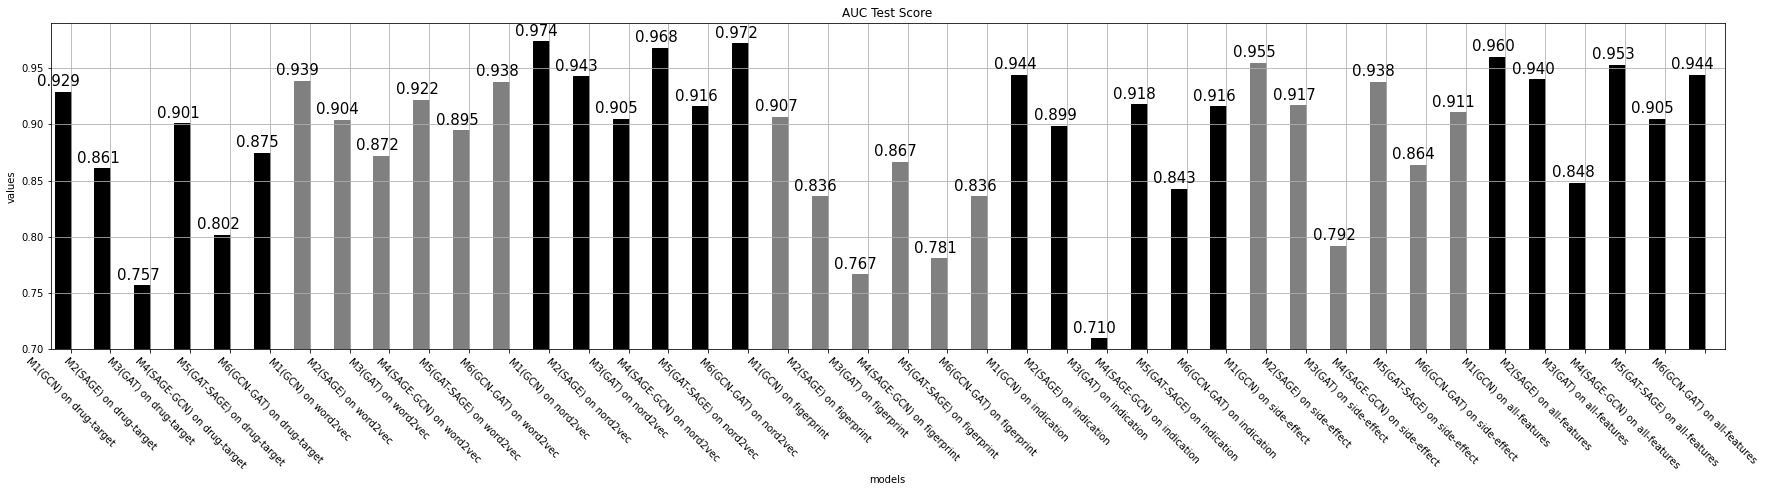

average AUC score: 0.8910476190476191


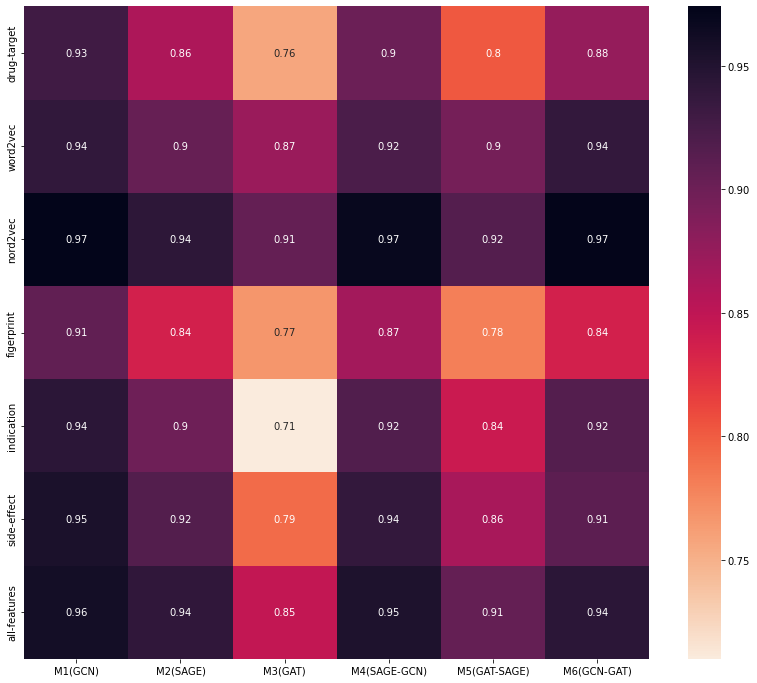

In [234]:
model_names = ['M1(GCN)', 'M2(SAGE)', 'M3(GAT)', 'M4(SAGE-GCN)', 'M5(GAT-SAGE)', 'M6(GCN-GAT)']
feature_names = ['drug-target', 'word2vec', 'nord2vec', 'figerprint', 'indication', 'side-effect', 'all-features']
colors = ['black', 'gray', 'black', 'gray', 'black', 'gray', 'black']
method_names = []
all_test = []

ave_list = []
for i in range(len(all_te_list)):
    ave = 0
    for j in range(len(all_te_list[0])):
        ave += all_te_list[i][j]
    ave = ave / len(all_te_list[0])
    ave_list.append(ave)
# calculating average on the models
ave_list = []
scores = []
for i in range(len(all_te_list)):
    ave = 0
    for j in range(len(all_te_list[0])):
        ave += all_te_list[i][j]
    ave = ave / len(all_te_list[0])
    ave_list.append(ave)
# printing models in a table visualization
print(' '* 15, end='')
for i, name in enumerate(model_names):
    print(f'{name:^15}', end='')
print()
for i in range(len(all_te_list)):
    model = feature_names[i]
    print(f'{feature_names[i]:^15}', end='')
    scores_list = []
    for j in range(len(all_te_list[0])):
        string = float("{:.3f}".format(all_te_list[i][j]))
        all_test.append(string)
        feature = model_names[j]
        print(f'{string:^15}' , end='')
        method_names.append(f'{feature} on {model}')
        scores_list.append(string)
    # scores_list.append(ave_list[i])
    scores.append(scores_list)
    print()
# barplot visualization
plotter(all_test, method_names, colors)
scores = np.array(scores)
scores = np.reshape(scores, (7, 6))
# computing overall score
heat_scores = scores[:]
sum = 0
for i in range(len(heat_scores)):
    for j in range(len(heat_scores[0])):
        sum += heat_scores[i][j]
print('average AUC score:', sum / 42)
# Heatmap visualization
cmap = sns.cm.rocket_r

plt.figure(figsize=(14, 12))
ax = sns.heatmap(scores, annot=True, cmap=cmap)
ax.set_xticklabels(model_names)
ax.set_yticklabels(feature_names)
plt.show()

# Loading new ddc predictions in one file

In [5]:
drug_names = decoding_drug_ids()

out_dir = str(pathlib.Path().resolve())
out_path = f'{out_dir}/new_predictions/model_and_features/'

all_edges = []
number_list = []

name_list = os.listdir(out_path)

for i, name in enumerate(name_list):
    out_file = f'{out_path}{name}'
    name = name.replace('.csv', '')
    try:
        df = pd.read_csv(out_file)
        for edge in df.iloc[:, 2:].values:
            edge = list(edge)
            d1 = drug_names[edge[0]]
            d2 = drug_names[edge[1]]
            number_list.append(i)
            row = [name, edge[0], edge[1], d1, d2]
            all_edges.append(row)
    except Exception as e:
        all_edges.append([name, '-', '-', '-', '-'])
        number_list.append(i)

all_edges = np.array(all_edges)

all_df = pd.DataFrame(number_list, columns=['typeNo'])
all_df['model_feature'] = all_edges[:, 0:1]
all_df['alias1'] = all_edges[:, 1:2]
all_df['alias2'] = all_edges[:, 2:3]
all_df['drug1'] = all_edges[:, 3:4]
all_df['drug2'] = all_edges[:, 4:5]
#############################################################
if 'new_predictions' not in os.listdir(f'{out_dir}/'):
    os.mkdir( f'{out_dir}/new_predictions/')
if 'new_edges' not in os.listdir(f'{out_dir}/new_predictions/'):
    os.mkdir( f'{out_dir}/new_predictions/new_edges/')
#############################################################
all_df.to_csv(f'{out_dir}/new_predictions/new_edges/new_ddc.csv', index=False)

# Loading dataframes and printing their info

In [6]:
final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df, all_df = load_dataframes()

print('drug target:', (final_dt_df.shape[1]-2))
print('word2vec:', (final_w2v_df.shape[1]-2))
print('fingerprint:', (final_fin_df.shape[1]-2))
print('node2vec:', (final_nv_df.shape[1]-2))
print('indication:', (final_in_df.shape[1]-2))
print('side effect:', (final_se_df.shape[1]-2))
print('--------------------------------------------')
print('drug target:', (final_dt_df.shape[0]))
print('word2vec:', (final_w2v_df.shape[0]))
print('fingerprint:', (final_fin_df.shape[0]))
print('node2vec:', (final_nv_df.shape[0]))
print('indication:', (final_in_df.shape[0]))
print('side effect:', (final_se_df.shape[0]))

drug target: 790
word2vec: 200
fingerprint: 167
node2vec: 128
indication: 1513
side effect: 3256
--------------------------------------------
drug target: 760
word2vec: 614
fingerprint: 627
node2vec: 752
indication: 383
side effect: 389


# Generating unique ddc pairs

In [7]:
base_dir = str(pathlib.Path().resolve())
in_path = f'{base_dir}/new_predictions/new_edges/new_ddc.csv'
df = pd.read_csv(in_path)
#############################################################
drug_pair_dict = dict()
for row in df.values:
    if row[2] == '-':
        pass
    else:
        pair = f'{row[4]} - {row[5]}'
        pair2 = f'{row[5]} - {row[4]}' 
        if pair in list(drug_pair_dict.keys()) or pair2 in list(drug_pair_dict.keys()):
            try:
                count = drug_pair_dict[pair]
                count += 1
                drug_pair_dict[pair] = count
            except Exception as e:
                count = drug_pair_dict[pair2]
                count += 1
                drug_pair_dict[pair2] = count
        else:
            drug_pair_dict[pair] = 1
#############################################################
d1_list = []
d2_list = []
pair_count = []
for key in list(drug_pair_dict.keys()):
    ds = key.split(' - ')
    d1_list.append(ds[0])
    d2_list.append(ds[1])
    pair_count.append(drug_pair_dict[key])
#############################################################
new_df = pd.DataFrame()
new_df['d1'] = d1_list
new_df['d2'] = d2_list
new_df['count'] = pair_count
new_df.sort_values('count', ascending=False, inplace=True)
new_df.to_csv(f'{base_dir}/new_predictions/new_edges/new_ddc_unique.csv', index=False)

# loading all edges with drug names (not ddc codes)

In [8]:
final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df, all_df = load_dataframes()

out_dir = str(pathlib.Path().resolve())
out_path = f'{out_dir}/datasets/dcdb.csv'

if 'dcdb.csv' not in os.listdir(f'{out_dir}/datasets/'):
    src_path = f'{out_dir}/datasets/COMPONENTS.txt'
    f = open(src_path, 'r')

    csv_1 = []
    csv_2 = []

    for line in f.readlines():
        each = line.split(' ')[0].split('\t')
        csv_1.append(each[0])
        csv_2.append(each[1])

    print(len(csv_1))
    print(len(csv_2))

    csv_1 = np.array(csv_1[1:])
    csv_2 = np.array(csv_2[1:])

    csv_1 = np.reshape(csv_1, (len(csv_1), 1))
    csv_2 = np.reshape(csv_2, (len(csv_2), 1))

    drug_df = pd.DataFrame(np.concatenate([csv_1, csv_2], axis=1), columns=['drug', 'name'])
    drug_df

    drug_df.to_csv(out_path, index=False)
else:
    drug_df = pd.read_csv(out_path)

drug_names = dict()

for drug in drug_df.values:
    drug = list(drug)
    drug_names[drug[0]] = drug[1]

all_edges = []

for edge in all_df.values:
    if list(edge) not in all_edges and [edge[1], edge[0]] not in all_edges:
        all_edges.append(list(edge))
        all_edges.append([edge[1], edge[0]])

d1_list = []
d2_list = []
t_list = []
for edge in all_edges:
    d1 = drug_names[edge[0]]
    d2 = drug_names[edge[1]]

    e1 = f'{d1}-{d2}'
    e2 = f'{d2}-{d1}'

    if e1 in t_list or e2 in t_list:
        pass
    else:
        t_list.append(e1)
        d1_list.append(d1)
        d2_list.append(d2)

df_all_names = pd.DataFrame()
df_all_names['d1'] = d1_list
df_all_names['d2'] = d2_list
df_all_names.to_csv(f'{out_dir}/datasets/all_edges_names.csv', index=False)

# Loading atc codes along with drug pairs

In [17]:
base_dir = f'{str(pathlib.Path().resolve())}/datasets'
dn_fname = 'dcdb_atc.csv'
path_dname = f'{base_dir}/{dn_fname}'
dn_df = pd.read_csv(path_dname)

base_path = f'{str(pathlib.Path().resolve())}'

all_new_edges_df = pd.read_csv(f'{base_path}/new_predictions/new_edges/new_ddc_unique.csv')

drug_atc_dict = dict()

for row in dn_df.values:
    drug = row[2]
    atc = row[3]
    atc_first = row[6]
    drug_atc_dict[drug] = [atc, atc_first]

drug_atc_dict

d1_atc_list = []
d2_atc_list = []

d1_atc_first_list = []
d2_atc_first_list = []

for row in all_new_edges_df.values:
    d1 = row[0]
    d2 = row[1]
    d1_atc_list.append(drug_atc_dict[d1][0])
    d2_atc_list.append(drug_atc_dict[d2][0])
    d1_atc_first_list.append(drug_atc_dict[d1][1])
    d2_atc_first_list.append(drug_atc_dict[d2][1])

all_new_edges_df['atc1'] = d1_atc_list
all_new_edges_df['atc2'] = d2_atc_list

all_new_edges_df['atc1_first'] = d1_atc_first_list
all_new_edges_df['atc2_first'] = d2_atc_first_list

all_new_edges_df.to_csv(f'{base_path}/new_predictions/new_edges/new_ddc_unique_with_atc.csv', index=False)
all_new_edges_df

,d1,d2,count,atc1,atc2,atc1_first,atc2_first
0,Lamivudine,Rifapentine,7,J05AF05,J04AB05,J,J
1,Hydrochlorothiazide,Nitrendipine,6,C03AA03,C08CA08,C,C
2,Lamivudine,Cobicistat,6,J05AF05,V03AX03,J,V
3,Lamivudine,Eucalyptol,6,J05AF05,R05CA13,J,R
4,Ceftriaxone,Ceftazidime,6,J01DD04,J01DD02,J,J
...,...,...,...,...,...,...,...
1461,Indapamide,Irbesartan,1,C03BA11,C09CA04,C,C
1462,Ipratropium,Budesonide,1,R01AX03,A07EA06,R,A
1463,Indapamide,Quetiapine,1,C03BA11,N05AH04,C,N
1464,Docetaxel,Aprepitant,1,L01CD02,A04AD12,L,A


# Temp